# Structure Preserving Operator Toolset (SPORT)

This notebook contains the prototypical algorithms and computational examples described Section V. in the paper *Identifying Systems with Symmetries using Equivariant Autoregressive Reservoir Computers* (2025). Specifically, this Jupyter Notebook includes sections V.A and V.B, corresponding to:

1. **Computational Example 1**: *Identification of a Hamiltonian system with symmetries using EARC*.
2. **Computational Example 2**: *Identification of a financial competition system with symmetries using EARC*.

SPORT consists of a collection of functions written in Python that can be used for sparse identification and numerical simulation of dynamical systems.

The numerical experiments programmed in this notebook use synthetic data generation and sparese model identification.

## Components of Algorithm 1: EARC Model Identification

### `SpaRCSim.py`
Reservoir computer simulator

In [20]:
"""
Created on Fri Apr 29 15:27:32 2022
SpaRCSim  Reservoir computer simulator
   Code by Fredy Vides
   For Paper, "Computing Sparse Reservoir Computers"
   by F. Vides
@author: Fredy Vides
"""

def SpaRCSim(w,x0,tp,N):
    from numpy import zeros
    # from NLMap import NLMap

    lx = len(x0)
    r = zeros((lx,N+1))
    r[:,0] = x0

    for k in range(N):
        r[:,k+1] = w@NLMap(r[:,k],tp)

    return r

### `RCDataGen.py`
Data generator for the recurrent reservoir computer

In [21]:
"""
Created on Sun Jul 10 10:53:58 2022
RCDataGen Data generator for the recurrent reservoir computer
@author: doctor
"""

def RCDataGen(data,L,S,ss,tp):
    from numpy import zeros
    from scipy.linalg import hankel
    # from RFactor import RFactor
    # from RNLMap import RNLMap


    def DataGenerator(X,R,tp,r):
        Y = zeros((r.shape[0],R))
        for j in range(R):
            Y[:,j] = RNLMap(r,X[:,j],tp)
        return Y

    data = data[:,0:S:ss]
    s = data.shape
    sL = s[0]*L
    S = s[1]
    R = S-L+1

    r = RFactor(s[0], L, tp)

    Ldata = zeros((sL,R))
    for k in range(s[0]):
        Ldata[k*L:(k+1)*L,:] = hankel(data[k,:L],data[k,(L-1):S])

    D = DataGenerator(Ldata,R,tp,r)

    return D,r

### `spsolver.py`
Sparse linear least squares solver

In [22]:
"""
Created on Wed Mar 31 02:57:52 2021
SPSOLVER  Sparse linear least squares solver
   Code by Fredy Vides
   For Paper, "Computing Sparse Semilinear Models for Approximately Eventually Periodic Signals"
   by F. Vides
@author: Fredy Vides
"""

def spsolver(A,Y,L=100,mode = "ls",nz=100,tol=1e-2,delta=1e-2):
    from numpy.linalg import svd,norm,lstsq
    from numpy import zeros,dot,diag,argsort,inf
    N = A.shape[1]
    M = Y.shape[1]
    if nz<0:
        nz = N
    X=zeros((N,M))
    u,s,v=svd(A,full_matrices=0)
    rk=sum(s>tol)
    u=u[:,:rk]
    s=s[:rk]
    s=1/s
    s=diag(s)
    v=v[:rk,:]
    A=dot(u.T,A)
    Y=dot(u.T,Y)
    X0=dot(v.T,dot(s,Y))
    for k in range(M):
        w=zeros((N,))
        K=1
        Error=1+tol
        c=X0[:,k]
        x0=c
        ac=abs(c)
        f=argsort(-ac)
        N0=int(min(sum(ac[f]>delta),nz))
        while (K<=L) & (Error>tol):
            ff=f[:N0]
            X[:,k]=w
            if mode == "ls":
                c = lstsq(A[:,ff],Y[:,k],rcond=None)[0]
                X[ff,k]=c
            else:
                u,s,v=svd(A[:,ff],full_matrices=0)
                rk=sum(s>tol)
                u=u[:,:rk]
                s=s[:rk]
                s=1/s
                s=diag(s)
                v=v[:rk,:]
                c = dot(v.T,dot(s,dot(u.T,Y[:,k])))
            X[ff,k] = c
            Error=norm(x0-X[:,k],inf)
            x0=X[:,k]
            ac=abs(x0)
            f=argsort(-ac)
            N0=int(min(sum(ac[f]>delta),nz))
            K=K+1
    return X

### `RFactor.py`
R-factor for generation of RC-data

In [23]:
"""
Created on Wed Jul 13 15:47:34 2022
RFactor
@author: doctor
"""

def RFactor(s,L,tp,method = "random",tol = 1e-15, scale = 1e0):
    from numpy import zeros, where, vstack
    # from NLMap import NLMap
    sL = s*L
    if method == "random":
        from numpy.random import randn
        z = scale*randn(sL,1)
        z = NLMap(z, tp)
        z[-1] = scale*randn()
    elif method == "prime":
        from PrimeGenerator import PrimeGenerator
        z0 = PrimeGenerator(sL+1,int(sL/2))
        z = NLMap(z0[:-1], tp)
        z[-1] = z0[-1]
    N = int((sL**(tp+1)-sL)/(sL-1))+1
    w0 = zeros((1,N))
    R = w0.copy()
    R[0,0] = 1
    for j in range(1,N):
        f = where(abs(z-z[j])<tol)
        if f[0][0] == j:
            w0[0,f] = 1
            R = vstack((R,w0/len(f[0])))
            w0[0,f] = 0
    return R

In [24]:
"""
Created on Wed Jul 13 15:47:34 2022
RFactor
@author: doctor
"""

def SRFactor(s,L,tp,method = "random",tol = 1e-15, scale = 1e0):
    from numpy import zeros, where, vstack
    # from NLMap import NLMap
    sL = s*L
    if method == "random":
        from numpy.random import randn
        z = scale*randn(sL,1)
        z = NLMap(z, tp)
        z[-1] = scale*randn()
    elif method == "prime":
        from PrimeGenerator import PrimeGenerator
        z0 = PrimeGenerator(sL+1,int(sL/2))
        z = NLMap(z0[:-1], tp)
        z[-1] = z0[-1]
    N = int((sL**(tp+1)-sL)/(sL-1))+1
    w0 = zeros((1,N))
    R = w0.copy()
    R[0,0] = 1
    for j in range(1,N):
        f = where(abs(z-z[j])<tol)
        if f[0][0] == j:
            w0[0,f] = 1
            R = vstack((R,w0))
            w0[0,f] = 0
    return R

### `RNLMap.py`
Reduced nonlinear data mapping

In [25]:
"""
Created on Fri Apr 29 14:58:40 2022
RNLMap Reduced nonlinear data mapping
   Code by Fredy Vides
   For Paper, "Computing Sparse Semilinear Models for Approximately Eventually Periodic Signals"
   by F. Vides
@author: Fredy Vides
"""
def RNLMap(R,x,tp):
    from numpy import append, kron
    p = x
    q = p
    for k in range(tp-1):
        q = kron(x,q)
        p = append(p,q)
    p = R@append(p,1)
    return p

### `NLMap.py`
Nonlinear data mapping

In [26]:
"""
Created on Fri Sept 29 15:27:32 2022
NLMap Nonlinear data mapping
   Code by Fredy Vides
   For Paper, "Approximating equivariant evolution operators with
   recurrent reservoir computers"
   by F. Vides
@author: Fredy Vides
"""

def NLMap(x,tp):
    from numpy import append, kron
    p = x
    q = p
    for k in range(tp-1):
        q = kron(x,q)
        p = append(p,q)
    p = append(p,1)
    return p

## Compare EARC to NGRC

### `SRC.py`
Non-Structured Sparse reservoir computer identifier

In [27]:
"""
Created on Sept 2023
SpaRC  Sparse reservoir computer identifier
   Code by Fredy Vides
   For Paper, "Dynamic financial processes identification using sparse regressive
   reservoir computers"
   by F. Vides
@author: Fredy Vides
"""

def SRC(data,L,S,ss,tp,nz,tol):
    from scipy.linalg import pinv
    from numpy import identity

    s = data.shape
    sL = s[0]*L
    R = s[1]-L+1

    D,r = RCDataGen(data,L,S,ss,tp)

    w0 = D[:sL,1:]@pinv(D[:,:-1])
    return w0,D,r

### `comparative_metrics.py`
Table and graph generator for Experiment's estimation of RMSE and $\Delta_{EM}$

In [28]:
def comparative_metrics(mdata, EMconst0,RMSE0,y0,t=None,z=None,exp=None):
    from numpy.linalg import norm
    from numpy import identity
    from math import sqrt
    from matplotlib.pyplot import figure, grid, tight_layout, show, plot, xlabel, ylabel, axis
    params=mdata[0]
    groups=mdata[1]

    X=params[0]
    L = X.shape[0]
    s = X.shape[1]

    solver= params[1]
    l=params[2]
    S=params[3]*2
    ss=params[4]
    tp=params[5]
    nz=params[6]
    tol=params[7]
    delta=params[8]

    w,data,r = SRC(X.T,l,S,ss,tp,nz,tol)
    wr = w@r
    y = SpaRCSim(wr,data[:s*l,-1],tp,L-S+l-1)
    g1=groups[0]
    G1=groups[1]
    if exp == "Fin":
        EMconst1 = 0
        X0 = z.T[(S-1):]
        y_hat = y.T
        RMSE1 = sqrt(norm(y_hat-X0)**2/(X0.shape[0]*X0.shape[1]))
        h1 = identity(g1.shape[0])
        H1 = identity(G1.shape[0])

        fig0 = figure()
        ax00 = fig0.add_subplot(2,1,1)

        lines = ax00.plot(t, z.T, 'g', linewidth=1, linestyle='solid')
        lines[0].set_label('reference')
        lines = ax00.plot(t[:(S-l)], z[:, :(S-l)].T, 'b', linewidth=1, linestyle='dashed')
        lines[0].set_label('training data')
        lines = ax00.plot(t[(S-l):], y.T, color='darkorange', linewidth=1, linestyle=(0, (1, 1)))
        lines[0].set_label('predicted NGRC')
        ax00.set_ylabel('Representation ranking')
        axis('tight')
        grid('on')

        ax01 = fig0.add_subplot(2,1,2)
        lines = ax01.plot(t, z.T, 'g', linewidth=1, linestyle='solid')
        lines[0].set_label('reference')
        lines = ax01.plot(t[:(S-l)], z[:, :(S-l)].T, 'b', linewidth=1, linestyle='dashed')
        lines[0].set_label('training data')
        lines = ax01.plot(t[params[3]-l:], y0.T, 'r', linewidth=1, linestyle=(0, (1, 1)))
        lines[0].set_label('predicted EARC')
        ax01.set_xlabel('t (months)')
        ax01.set_ylabel('Representation ranking')
        axis('tight')
        grid('on')

        ax00.legend(loc=7, fontsize='x-small')
        ax01.legend(loc=7, fontsize='x-small')
        show()


        fig0.savefig("fig_Financial_competition_dynamics_comp.png",dpi=1000,format='png')
        for k in range(5):
            EMconst1 = EMconst1 + norm(h1@wr-wr@H1)
            h1 = h1@g1
            H1 = H1@G1

    else:
        X0 = X[(S-l):,:].T
        y_hat = y[[0,l],:]
        RMSE1 = sqrt(norm(y_hat-X0)**2/(X0.shape[0]*X0.shape[1]))
        g2 = groups[2]
        G2 = groups[3]
        EMconst1 = norm(g1@wr-wr@G1)+norm(g2@wr-wr@G2)+norm(g1@g2@wr-wr@G1@G2)

        fig0 = figure()
        ax00 = fig0.add_subplot(1,2,1)
        ax00.plot(X[(S-l):,0],X[(S-l):,1],'g',linewidth=1,linestyle='solid',label='reference')
        ax00.plot(y[0,:].T,y[l,:].T,color='darkorange', linewidth=1,linestyle=(0, (1, 5)),label='predicted NGRC')
        grid(color='k', linestyle='--', linewidth=0.5)
        tight_layout()
        ax00.legend(loc=2,fontsize='x-small')
        ax00 = fig0.add_subplot(1,2,2)
        ax00.plot(X[(S-l):,0],X[(S-l):,1],'g',linewidth=1,linestyle='solid',label='reference')
        ax00.plot(y0[0,:].T,y0[l,:].T,'r',linewidth=1,linestyle=(0, (1, 1)),label='predicted EARC')
        grid(color='k', linestyle='--', linewidth=0.5)
        tight_layout()
        ax00.legend(loc=2,fontsize='x-small')
        show()
        fig0.savefig('fig_hamiltonianSystemID_graph_comp.png',dpi=1000,format='png')

    return RMSE0, RMSE1, EMconst0,EMconst1

## COMPUTATIONAL EXAMPLE 1: Identification of a Hamiltonian system with symmetries using EARC

Let us consider a Hamiltonian system determined by the following initial value problem.
$
\begin{align}
&\frac{d q}{dt}=p^3-p,\\
&\frac{d p}{dt}=q^3-q, \nonumber\\
&q(0)=1,p(0)=0\nonumber
\end{align}
$

### `HamiltonianSystemID.py`
#### Hamiltonian System Identification with symmetries using EARC
The function `HamiltonianSystemID(·)` runs the first experiment as described in Section V.A of Vides et. al 2025.

In [29]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Nov 12 11:07:42 2023
Example 1:
    from HamiltonianSystemID import HamiltonianSystemID
    wr,w0,r,EMconst = HamiltonianSystemID(600)
@author: Fredy Vides, Department of Statistics and Research, CNBS, Honduras
"""
def HamiltonianSystemID(S):
    # from HamiltonianSystem import HamiltonianSystem
    # from K4SymProjector import K4SymProjector
    # from SpaRCSim import SpaRCSim
    from matplotlib.pyplot import figure,show,grid,tight_layout
    from numpy import array, kron, identity, zeros
    from numpy.linalg import norm
    from math import sqrt
    from time import time

    t,X = HamiltonianSystem()
    K4gen = array([[0,1,-1,0],[1,0,0,-1]])
    L = X.shape[0]
    s = X.shape[1]
    l = 5
    tp = 3
    nz = int(s*l+(s*l)*(s*l+1)/2+(s*l)**3+1)
    g1 = kron(K4gen[:,:s],identity(l))
    g2 = kron(K4gen[:,s:],identity(l))
    dn = int(((s*l)**(tp+1)-s*l)/(s*l-1)+1)
    G1 = zeros((dn,dn))
    G2 = zeros((dn,dn))
    G1[:s*l,:s*l] = g1
    G1[s*l:((s*l)**(tp-1)+s*l),s*l:((s*l)**(tp-1)+s*l)] = kron(g1,g1)
    G1[((s*l)**(tp-1)+s*l):-1,((s*l)**(tp-1)+s*l):-1] = kron(g1,kron(g1,g1))
    G1[-1,-1] = 1
    G2[:s*l,:s*l] = g2
    G2[s*l:((s*l)**(tp-1)+s*l),s*l:((s*l)**(tp-1)+s*l)] = kron(g2,g2)
    G2[((s*l)**(tp-1)+s*l):-1,((s*l)**(tp-1)+s*l):-1] = kron(g2,kron(g2,g2))
    G2[-1,-1] = 1
    groups = (g1,G1,g2,G2)
    t0 = time()
    w0,data,r = K4SymProjector(X.T,"svd",l,S,1,tp,nz,g1,g2,G1,G2,1e-3,1e-4)
    wr = w0@r
    print("Elapsed time: ",time()-t0)
    y = SpaRCSim(wr,data[:s*l,-1],tp,L-S+l-1)

    X0 = X[(S-l):,:].T
    y_hat = y[[0,l],:]
    RMSE = sqrt(norm(y_hat-X0)**2/(X0.shape[0]*X0.shape[1]))

    EMconst = norm(g1@wr-wr@G1)+norm(g2@wr-wr@G2)+norm(g1@g2@wr-wr@G1@G2)

    mdt = (X,"svd",l,S,1,tp,nz,1e-3,1e-4)
    mdata =  (mdt,groups)
    return wr,w0,r,EMconst,RMSE,mdata,y

### `HamiltonianSystem.py`:
#### Hamiltonian System Synthetic Signal Generator
The function `HamiltonianSystem(·)` computes the synthetic signals corresponding to the data sample $\Sigma_{600} \subset \mathbb{R}^3$. Using lsoda from the FORTRAN library odepack via the Python function odeint.

In [30]:
"""
Created on Fri Apr 29 19:30:41 2022
Lorenz system simulator
@author: Fredy Vides
"""

def HamiltonianSystem(q0 = 1.0, p0 = 0.0):
    from numpy import arange
    from scipy.integrate import odeint

    def Hamiltonian(state, t):
        q, p = state

        dq = p**3-9*p
        dp = q**3-9*q
        return [dq, dp]

    y0 = [q0, p0]
    t = arange(0.0, 40.0, 0.01)

    z = odeint(Hamiltonian, y0, t, rtol = 1e-10, atol = 1e-10)

    return t,z

### `K4SymProjector.py`:
#### K4-Symmetric Projector

The system generated in the function `HamiltionianSystem(·)` is $K_4$-equivariant. For the configuration used for this experiment, the matrix representation $\mathbf{G}_{\boldsymbol{\pi}}(K_4)$ of the corresponding group of symmetries $$K_4=\left\langle r_1,r_2\left| r_1^2=r_2^2=\left(r_1r_2\right)^2=e\right.\right\rangle$$
is determined by the following assignments.
\begin{align*}
r_1&\mapsto r_{1,\boldsymbol{\rho}} =\begin{bmatrix}
0 & 1\\
1 & 0
\end{bmatrix}\\
r_2&\mapsto r_{2,\boldsymbol{\rho}}= \begin{bmatrix}
-1 & 0\\
0 & -1
\end{bmatrix}
\end{align*}

In [31]:
"""
Created on Fri Jul 15 20:40:07 2022
K4-symmetric projector
@author: Fredy Vides
"""

def K4SymProjector(data,solver,L,S,ss,tp,nz,g1,g2,G1,G2,tol,delta):
    from numpy import reshape, identity, kron, diag, zeros
    from scipy.linalg import svd
    # from RCDataGen import RCDataGen
    # from spsolver import spsolver

    s = data.shape
    sL = s[0]*L
    R = s[1]-L+1

    D,r = RCDataGen(data,L,S,ss,tp)
    D0 = D[:,:-1]
    D1 = D[:sL,1:]

    ri = r.T@diag(1/diag(r@r.T))
    k1 = g1
    k2 = g2
    K1 = r@G1@ri
    K2 = r@G2@ri
    n = (sL,D.shape[0])
    m = n[0]*n[1]
    n1 = (sL,D0.shape[1])
    m1 = n1[0]*n1[1]
    E = identity(m)
    K1 = kron(K1,k1)-E
    K2 = kron(K2,k2)-E
    K = K1.T@K1 + K2.T@K2
    u,rk,_ = svd(K,full_matrices=0)
    rk = sum(rk>tol*1e-5)
    u = u[:,rk:]
    us = u.shape[1]
    W0 = zeros((m1,us))
    for j in range(us):
        w0 = reshape(u[:,j],(n[1],n[0])).T
        w0 = w0@D0
        W0[:,j] = reshape(w0, (m1))
    W1 = reshape(D1, (m1,1))
    c = spsolver(W0,W1,R,solver,nz,tol,delta)
    wr = reshape(u@c,(n[1],n[0])).T

    return wr,D,r

### Results: Identified signals

In [32]:
wr,w0,r,EMconst,RMSE,mdata,y = HamiltonianSystemID(600)

Elapsed time:  28.597688674926758


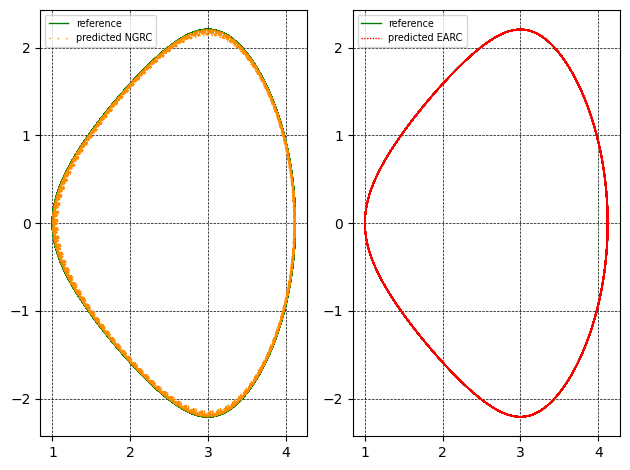

In [33]:
RMSE_s1, RMSE_n1, EMconst_s1,EMconst_n1 = comparative_metrics(mdata, EMconst, RMSE, y)

## COMPUTATIONAL EXAMPLE 2: Identification of a financial competition system with symmetries using EARC

Let us consider a discrete-time financial competition system for $5$ banks, characterized by the following recurrence relation:

\begin{align}
\mathbf{p}(t+1)=\mathbf{p}(t)+\mathbf{r}\odot \mathbf{p}(t)\odot(\mathbf{1}_5-\mathbf{N}\mathbf{p}(t))
\end{align}


In this model, the $i$-th component $\mathbf{p}(t)[i]$ of each vector $\mathbf{p}(t)$ is an approximate representation for the value at time step $t$, of the discrete-time signal determined by the smoothed evolution of the representation ranking of bank $i$ in a given market or portfolio, as assessed by some regulating body.

The matrix $\mathbf{N}$, is defined as:
\begin{align*}
\mathbf{N}& =\begin{bmatrix}
1 &  1.1 & 0 &  0 &  1 \\
 1 & 1 & 1.1 & 0 & 0 \\
 0 & 1 & 1 & 1.1 & 0 \\
 0 & 0 & 1 & 1 & 1.1 \\
 1.1 & 0 & 0 & 1 & 1
\end{bmatrix}
\end{align*}
and represents the interaction between banks of the system under consideration. It corresponds to the expected interaction network $\mathcal{N}=(V_\mathcal{N},E_{\mathcal{N}})$ of the $5$ banks considered in this experiment.

### `FinancialCompetitionSystem.py`
#### Financial competition simulation
The function `FinancialCompetitionSystem()` runs the second experiment as described in Section V.B of Vides et. al 2025.

In [34]:
"""
Created on Fri Apr 29 19:30:41 2022
Financial competition simulation
Example:
    from FinancialCompetitionSystem import FinancialCompetitionSystem
    t,z,wr,g1,G1,G,EMconst,r = FinancialCompetitionSystem(.376,1,1,1.1,31)
@author: Fredy Vides, Department of Statistics and Research, CNBS, Honduras
"""

def FinancialCompetitionSystem(r,a,b,c,S):
    from numpy import zeros, ones, linspace, identity, kron, where, hstack, savetxt
    from numpy.linalg import norm
    from math import sqrt
    # from Z5SymProjector import Z5SymProjector
    # from SpaRCSim import SpaRCSim
    from networkx import DiGraph, draw_networkx
    from matplotlib.pyplot import plot, show, xlabel, ylabel, axis, grid, figure

    L = 425
    l = 1
    s = 5
    t = linspace(0,14,L)
    z = zeros((s,L))
    tp = 2
    nz = int(s*l+(s*l)*(s*l+1)/2+1)

    z[:,0] = [0.9 , 0.95, 0.7, 0.55, .5]
    C = MatGen(a,b,c,s)

    for k in range(1,L):
        z[:,k:k+1] = system_rhs(z[:,k-1:k],r,C)

    savetxt('CompetitionModelData.csv', z.T, delimiter =',')

    g1 = identity(5)
    g1 = g1[:,[4,0,1,2,3]]

    G1 = zeros((s*l+(s*l)**2+1,s*l+(s*l)**2+1))
    G1[:s*l,:s*l] = g1
    G1[s*l:-1,s*l:-1] = kron(G1[:s*l,:s*l],G1[:s*l,:s*l])
    G1[-1,-1] = 1



    w0,data,r,mdt = Z5SymProjector(z,"svd",l,S,1,tp,nz,g1,G1,1e-3,1e-4)
    wr = w0@r
    y = SpaRCSim(wr,data[:s*l,-1],tp,L-S+l-1)

    nodes = []
    edges = []
    st = []
    tt = []
    for j in range(s):
        f0 = where(C[j,:]>0)[0]
        nodes.append(j)
        tt = hstack((tt,f0))
        st = hstack((st,j*ones(len(f0))))

    st = st.astype('int')
    tt = tt.astype('int')
    for k in range(len(st)):
        edges.append((st[k],tt[k]))

    nodes = list(map(lambda x: x+1,nodes))
    edges = list(map(lambda x: (x[0]+1,x[1]+1),edges))

    G = DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    fig1 = figure()
    draw_networkx(G, node_color = 'green')
    show()
    fig1.savefig('fig_Financial_competition_graph.png',dpi=600,format='png')

    X0 = z.T[(S-1):]
    y_hat = y.T
    RMSE = sqrt(norm(y_hat-X0)**2/(X0.shape[0]*X0.shape[1]))


    EMconst = 0
    h1 = identity(g1.shape[0])
    H1 = identity(G1.shape[0])
    for k in range(5):
        EMconst = EMconst + norm(g1@wr-wr@G1)
        h1 = h1@g1
        H1 = H1@G1

    groups = (g1,G1)
    mdata = (mdt,groups)

    return t,z,wr,g1,G1,G,EMconst,r,RMSE,mdata,y

def MatGen(a,b,c,n):
    from numpy import diag,ones
    C = diag(ones(n-1),1)
    C[-1,0] = 1
    return a*C.T+b*diag(ones(n))+c*C

def system_rhs(s,r,C):
    return s + r*s*(1-C@s)

### `Z5SymProjector.py`
When all components of the growth vector $\mathbf{r}$ are equal, the system becomes $\mathbb{Z}_5$-equivariant. For the configuration used for this experiment, $\mathbf{r}=0.376\mathbf{1}_5$ and the matrix representation $\mathbf{G}_{\boldsymbol{\pi}}(\mathbb{Z}_5)$ of the corresponding group of symmetries $\mathbb{Z}_5=\langle r| r^5=e\rangle$ is determined by the following assignment.
\begin{align*}
r&\mapsto r_{\boldsymbol{\rho}} =\begin{bmatrix}
0 & 1 & 0 & 0 & 0\\
0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 1\\
1 & 0 & 0 & 0 & 0\\
\end{bmatrix}
\end{align*}

In [35]:
"""
Created on Fri Jul 15 20:40:07 2022

@author: doctor
"""
def Z5SymProjector(data,solver,L,S,ss,tp,nz,g1,G1,tol,delta):
    from numpy import reshape, identity, kron, diag, zeros
    from scipy.linalg import svd
    # from RCDataGen import RCDataGen
    # from spsolver import spsolver

    s = data.shape
    sL = s[0]*L
    R = s[1]-L+1

    D,r = RCDataGen(data,L,S,ss,tp)
    D0 = D[:,:-1]
    D1 = D[:sL,1:]

    ri = r.T@diag(1/diag(r@r.T))
    K = r@G1@ri
    n = (sL,D.shape[0])
    m = n[0]*n[1]
    n1 = (sL,D0.shape[1])
    m1 = n1[0]*n1[1]
    E = identity(m)
    K = kron(K,g1)-E
    K = K.T@K
    u,rk,_ = svd(K,full_matrices=0)
    rk = sum(rk>1e-10)
    u = u[:,rk:]
    us = u.shape[1]
    W0 = zeros((m1,us))
    for j in range(us):
        w0 = reshape(u[:,j],(n[1],n[0])).T
        w0 = w0@D0
        W0[:,j] = reshape(w0, (m1))
    W1 = reshape(D1, (m1,1))
    c = spsolver(W0,W1,R,solver,nz,tol,delta)
    wr = reshape(u@c,(n[1],n[0])).T
    mdata = (data.T,solver,L,S,ss,tp,nz,tol,delta)
    return wr,D,r,mdata

### Results: Identified Siganals

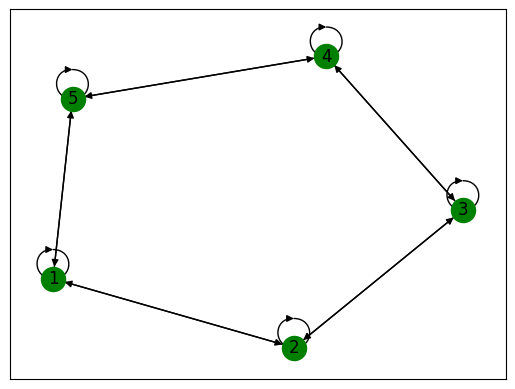

Equivariant Estimation d_em: 1.0778764377746607e-14
Equivariant Estimation RMSE: 1.1967603150389384e-12


In [36]:
t,z,wr,g1,G1,G,EMconst,r,RMSE,mdata,y = FinancialCompetitionSystem(.376,1,1,1.1,31)
print("Equivariant Estimation d_em:",EMconst)
print("Equivariant Estimation RMSE:",RMSE)

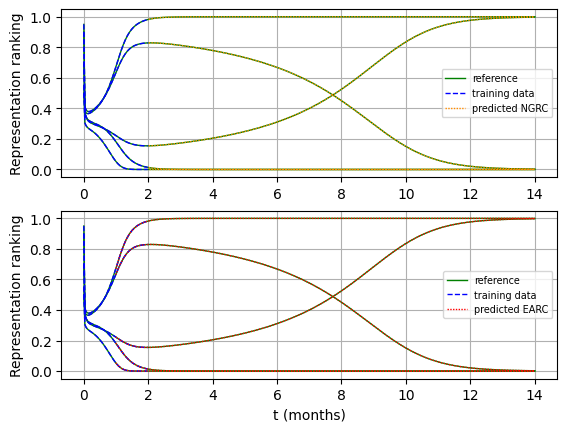

In [37]:
RMSE_s2, RMSE_n2, EMconst_s2,EMconst_n2 = comparative_metrics(mdata, EMconst, RMSE, y,t,z,exp="Fin")

# Table 1: Error Metrics

In [38]:
from pandas import DataFrame
DataFrame(data=[[RMSE_s1, RMSE_n1, EMconst_s1,EMconst_n1],[RMSE_s2, RMSE_n2, EMconst_s2,EMconst_n2]],
          index=["Exp1","Exp2"],
          columns=["RMSE_s", "RMSE_n", "EMconst_s","EMconst_n"])

,RMSE_s,RMSE_n,EMconst_s,EMconst_n
Exp1,7.902582e-05,1.335309e+00,3.120924e-15,3.165791e+00
Exp2,1.196760e-12,5.365852e-07,1.077876e-14,6.159721e-07


# References
1. Vides, F., Nogueira, I., Lopez Gutierrez, G., Banegas, L., Flores, E. (2025). Identifying Systems with Symmetries using Equivariant Autoregressive Reservoir Computers.
2. Vides, F., Nogueira, I., Banegas, L., Lopez Gutierrez, G., Flores, E. (2025). Dynamic financial processes identification using sparse regressive reservoir computers